In [24]:
import matplotlib.pyplot as plt
import plotly.io as pio
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from web3 import Web3
import requests
import json
from collections import defaultdict
from datetime import datetime
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 800)

# Scraping On-Chain Data + Analysis
The two below cells are how Arbitrum blockchain data was scraped using the Alchemy API endpoint 
## esGMX emissions to GLP and GMX holders/vesting

The only way that new GMX can enter the market is through the vesting of esGMX (escrowed GMX). The main way that esGMX is dispersed is through rewards to stakers of GMX and holders of GLP-- esGMX is also emitted through collaborations (Gammaswap, YieldYak, etc), however these emissions are in the minority. esGMX auto-stakes itself in order to earn more esGMX rewards, however, it can be vested/burned to convert into GMX. 

When esGMX is sent to GMX and GLP holders, it always goes through two of the same contracts-- the `RewardTracker` and the `RewardDistributor`. There are instances of these contracts instantiated for handling GMX and GLP, with a total of four unique addresses, which can be found here: https://github.com/gmx-io/gmx-interface/blob/6e11d2e99354b8cd4c2401ec1ed2d732cf4a8d74/src/config/contracts.ts

Therefore, we want to scrape for `erc20` asset transfers that go from the Tracker to the Distributor as it always goes through those two contracts for both GLP and GMX holders. 

### esGMX vesting
A similar pattern occurs when people vest/burn esGMX to transfer it into new GMX. There are two `Vester` contracts, the `gmxVester` and the `glpVester` that respective holders can vest their esGMX with, as seen here https://github.com/gmx-io/gmx-contracts/blob/7638fb94df20d0a43ca38035256dcf69dce563aa/scripts/staking/deployRewardRouterV2.js#L59-L77. We use the same Alchemy endpoint as the above, however we track `erc20` transfers from the Vester contract addresses to the null address, which indicates a burn event.



### Getting esGMX emissions to people who staked GMX

In [ ]:
## Here we are scraping all ERC20 transactions from the GMXRewardTracker to the GMXRewardDistributor

## this is how all esGMX emissions through staked GMX rewards are sent


## Note: this block isn't functional until dashes are replaced at the end of the `url` variable with your own 
## Alchemy API key

url = "https://arb-mainnet.g.alchemy.com/v2/------"

payload = {
    "id": 1,
    "jsonrpc": "2.0",
    "method": "alchemy_getAssetTransfers",
    "params": [
        {
            "fromBlock": "0x0",
            "toBlock": "latest",
            "fromAddress": "0x23208B91A98c7C1CD9FE63085BFf68311494F193",
            "toAddress": "0x908C4D94D34924765f1eDc22A1DD098397c59dD4",
            "category": ["erc20"],
            "withMetadata": False,
            "excludeZeroValue": True,
            "maxCount": "0x3e8"
        }
    ]
}
headers = {
    "accept": "application/json",
    "content-type": "application/json"
}

first_response = requests.post(url, json=payload, headers=headers)

data = json.loads(first_response.text)
esGMX_df = pd.json_normalize(data['result'], record_path = ['transfers'])

# set first pageKey
pageKey = data['result']['pageKey']

while len(pageKey) > 0:
    new_payload = defaultdict(dict)
    new_payload = payload
    new_payload["params"][0]["pageKey"] = pageKey
    response = requests.post(url, json=new_payload, headers = headers)
    data = json.loads(response.text)
    df = pd.json_normalize(data['result'], record_path = ['transfers'])
    esGMX_df = pd.concat([esGMX_df, df])
    
    pageKey = data['result']['pageKey']
    print("Next PageKey: " + pageKey)
    

# Run to save dataframe
#esGMX_df.to_csv(r'esGMX_emissions_GMX.csv')

### Getting timestamp data from Arbitrum block number

In [ ]:
for index, row in esGMX_GLP.iterrows():
    block = row['blockNum']
    payload = {
        "id": 1,
        "jsonrpc": "2.0",
        "method": "eth_getBlockByNumber"
    }
    headers = {
        "accept": "application/json",
        "content-type": "application/json"
    }
    new_payload = defaultdict(dict)
    new_payload = payload
    new_payload["params"] = [block, False]
    response = requests.post(url, json=new_payload, headers = headers)
    data = json.loads(response.text)
    res = int(data['result']['timestamp'],16)
    timestamps.append(datetime.utcfromtimestamp(res).strftime('%Y-%m-%d %H:%M:%S'))
    print(datetime.utcfromtimestamp(res).strftime('%Y-%m-%d %H:%M:%S'))
    
timestampcolumn = pd.Series(timestamps, copy=False)
esGMX_GLP['full_timestamp'] = timestampcolumn

esGMX_GLP.to_csv('esGMX_with_timestamp.csv')

## Process of esGMX emission/vesting data

Repeat the code block above, changing the from address and to address to reflect the GLP Reward Tracker and Distributor. This will return a dataframe containing all esGMX emissions to GLP holders.

A similar process is used when getting esGMX vesting data for both GMX and GLP holders, using the GMX and GLP Vesting contracts. These contract addresses can all be found https://github.com/gmx-io/gmx-interface/blob/6e11d2e99354b8cd4c2401ec1ed2d732cf4a8d74/src/config/contracts.ts#L119-L160

Whenever esGMX holders want to vest, the respective contracts send esGMX to the null address, burning them. So in that data pull, the `toAddress` should be the null address.

In [27]:
# load all arbiscan scraped data on esGMX emissions/burning
esGMX_GMX = pd.read_csv(r'esGMX_emissions_GMX.csv')
esGMX_GLP = pd.read_csv(r'esGMX_emissions_GLP.csv')
esGMX_burned_GMX = pd.read_csv(r'esGMX_burned_GMX.csv')
esGMX_burned_GLP = pd.read_csv(r'esGMX_burned_GLP.csv')

# read data with timestamps added -- this was scraped from Alchemy in a manner similar ot
esGMX_timestamps = pd.read_csv(r'esGMX_with_timestamp.csv')

# create copy of blocknumber to timestamp data to merge onto other datasets
timestamp_to_block_df = esGMX_timestamps.loc[:, ['blockNum','full_timestamp']]
timestamp_to_block_df['blockNum']=timestamp_to_block_df['blockNum'].astype(str)
esGMX_GLP['blockNum']=esGMX_GLP['blockNum'].astype(str)

esGMX_GLP = esGMX_GLP.merge(timestamp_to_block_df, on = 'blockNum', how='left')
esGMX_burned_GMX = esGMX_burned_GMX.merge(timestamp_to_block_df, on = 'blockNum', how = 'left')
esGMX_burned_GLP = esGMX_burned_GLP.merge(timestamp_to_block_df, on = 'blockNum', how = 'left')

# add column making timestamp datetime object
esGMX_timestamps['datetime_object'] = pd.to_datetime(esGMX_timestamps['full_timestamp'], format='%Y-%m-%d %H:%M:%S')
esGMX_GLP['datetime_object'] = pd.to_datetime(esGMX_GLP['full_timestamp'], format='%Y-%m-%d %H:%M:%S')
esGMX_burned_GMX['datetime_object'] = pd.to_datetime(esGMX_burned_GMX['full_timestamp'], format='%Y-%m-%d %H:%M:%S')
esGMX_burned_GLP['datetime_object'] = pd.to_datetime(esGMX_burned_GLP['full_timestamp'], format='%Y-%m-%d %H:%M:%S')

<ipython-input-27-020627c16bb8>:8: DtypeWarning:

Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.



In [28]:
esGMX_burned_GMX_daily = esGMX_burned_GMX.resample('D', on='datetime_object')['value'].sum().to_frame().rename(columns={"value": "esGMX_burned_GMX"})
esGMX_burned_GLP_daily = esGMX_burned_GLP.resample('D', on='datetime_object')['value'].sum().to_frame().rename(columns={"value": "esGMX_burned_GLP"})

esGMX_burned_GMX_daily.reset_index(inplace=True)
esGMX_burned_GLP_daily.reset_index(inplace=True)


esGMX_burned_daily = esGMX_burned_GMX_daily.merge(esGMX_burned_GLP_daily, on = 'datetime_object', how = 'left')
esGMX_burned_daily['cumulative_esGMX_burned_GMX'] = esGMX_burned_daily['esGMX_burned_GMX'].cumsum()
esGMX_burned_daily['cumulative_esGMX_burned_GLP'] = esGMX_burned_daily['esGMX_burned_GLP'].cumsum()
# Filling the datetime object so we don't drop esGMX emitted values, this is synthetic date data but it is fine
esGMX_GLP['datetime_object'] = esGMX_GLP['datetime_object'].fillna(method='ffill')
esGMX_timestamps['datetime_object'] = esGMX_timestamps['datetime_object'].fillna(method='ffill')
esGMX_GLP_daily = esGMX_GLP.dropna(subset = 'datetime_object').resample('D', on='datetime_object')['value'].sum().to_frame().rename(columns={"value": "esGMX_GLP"})
esGMX_GMX_daily = esGMX_timestamps.dropna(subset = 'datetime_object').resample('D', on='datetime_object')['value'].sum().to_frame().rename(columns={"value": "esGMX_GMX"})

esGMX_GLP_daily.reset_index(inplace = True)
esGMX_GMX_daily.reset_index(inplace = True)

## Calculate cumulative totals on a daily basis
esGMX_GLP_daily['cumulative_esGMX_GLP'] = esGMX_GLP_daily['esGMX_GLP'].cumsum()
esGMX_GMX_daily['cumulative_esGMX_GMX'] = esGMX_GMX_daily['esGMX_GMX'].cumsum()

In [29]:
## Need to sum esGMX emitted monthly and sum esGMX burned monthly by holder type

In [30]:
esGMX_daily = esGMX_GMX_daily.merge(esGMX_GLP_daily, on = 'datetime_object', how = 'left')

In [31]:
esGMX  = esGMX_daily.merge(esGMX_burned_daily, on = 'datetime_object', how = 'left')
esGMX = esGMX[['datetime_object', 'esGMX_GMX', 'cumulative_esGMX_GMX', 'esGMX_GLP', 'cumulative_esGMX_GLP', 'esGMX_burned_GMX', 'esGMX_burned_GLP', 'cumulative_esGMX_burned_GMX', 'cumulative_esGMX_burned_GLP']]
# Dropping NA values in these columns for easier chart visualization
esGMX = esGMX.dropna(subset = ['esGMX_GLP', 'cumulative_esGMX_GLP', 'esGMX_burned_GMX', 'esGMX_burned_GLP'])

esGMX['Percent esGMX Vested GLP Holders Cumulative'] = (100 * (esGMX['cumulative_esGMX_burned_GLP'] / esGMX['cumulative_esGMX_GLP'])).round(2)
esGMX['Percent esGMX Vested GMX Holders Cumulative'] = (100 * (esGMX['cumulative_esGMX_burned_GMX'] / esGMX['cumulative_esGMX_GMX'])).round(2)

## esGMX emissions vs burned by holder type viz
The chart below visualizes esGMX emissions on a by holder basis as well as burned, cumulative. This graph shows us that GLP holders of esGMX vest at a much larger rate than GMX holders. This indicates that GLP holders do not believe in the value of the GMX token, since they want to vest to GMX immediately rather than holding esGMX for more esGMX rewards (that could be vested into more GMX down the line).

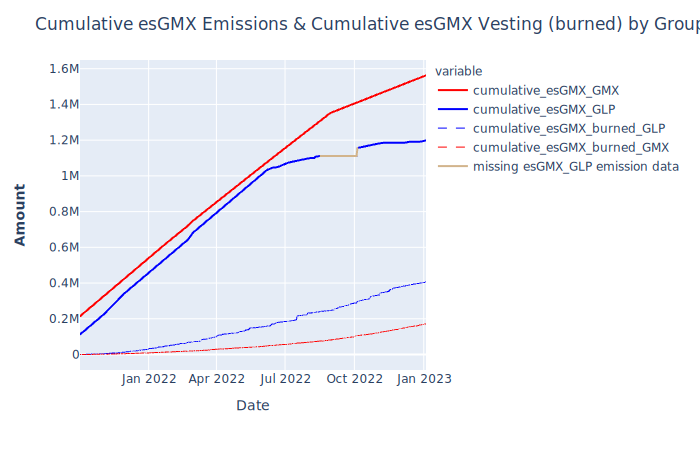

In [32]:
# Create mask to highlight the incomplete esGMX emissions to GLP data from August 2022 to October 2022
mask = (esGMX['datetime_object'] >= '2022-8-17') & (esGMX['datetime_object'] <= '2022-10-05')


fig = px.line(esGMX, x='datetime_object', y=['cumulative_esGMX_GMX', 'cumulative_esGMX_GLP',
                                             'cumulative_esGMX_burned_GLP', 'cumulative_esGMX_burned_GMX'
                                            ],
             color_discrete_sequence=['red', 'blue', 'blue', 'red'])

# Add dashed lines 
fig.update_traces(patch={"line": {"color": "blue", "width": 1, "dash": 'dash'}}, selector={"legendgroup": "cumulative_esGMX_burned_GLP"}) 
fig.update_traces(patch={"line": {"color": "red", "width": 1, "dash": 'dash'}}, selector={"legendgroup": "cumulative_esGMX_burned_GMX"}) 
# Add segment showing where incomplete data 
fig.add_scattergl(x=esGMX['datetime_object'].loc[mask], y=esGMX['cumulative_esGMX_GLP'].loc[mask], name = 'missing esGMX_GLP emission data',
                  line={'color': 'tan'})

# Add figure title
fig.update_layout(
    title_text="Cumulative esGMX Emissions & Cumulative esGMX Vesting (burned) by Group"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Amount</b> ", secondary_y=False)

fig.show(renderer="svg")



### esGMX monthly calc, cumulative

In [33]:
esGMX_monthly = esGMX.resample('M', on='datetime_object').last()
esGMX_monthly.reset_index(inplace = True)

In [34]:
esGMX_percent_vested_monthly_cumulative = esGMX_monthly.merge(esGMX, on = 'datetime_object',how = 'left').dropna()

In [35]:
esGMX_percent_vested_monthly_cumulative = esGMX_monthly[['datetime_object', 'Percent esGMX Vested GLP Holders Cumulative',
                                                                                  'Percent esGMX Vested GMX Holders Cumulative']].rename(columns={"datetime_object": "Date"})
esGMX_percent_vested_monthly_cumulative['Percent esGMX Vested GLP Holders Cumulative'] = esGMX_percent_vested_monthly_cumulative['Percent esGMX Vested GLP Holders Cumulative'].astype(str) + '%'
esGMX_percent_vested_monthly_cumulative['Percent esGMX Vested GMX Holders Cumulative'] = esGMX_percent_vested_monthly_cumulative['Percent esGMX Vested GMX Holders Cumulative'].astype(str) + '%'

## Percent of esGMX vested by holder type
esGMX is vested at a much higher rate by holders that derive esGMX from GLP (liquidity providers) versus holders that derived it from GMX. 

In [36]:
esGMX_percent_vested_monthly_cumulative

,Date,Percent esGMX Vested GLP Holders Cumulative,Percent esGMX Vested GMX Holders Cumulative
0,2021-10-31,1.85%,0.43%
1,2021-11-30,3.84%,1.07%
2,2021-12-31,6.29%,1.64%
3,2022-01-31,9.21%,2.27%
4,2022-02-28,10.43%,2.67%
5,2022-03-31,12.37%,3.43%
6,2022-04-30,13.63%,3.89%
7,2022-05-31,15.36%,4.24%
8,2022-06-30,17.3%,4.85%
9,2022-07-31,21.04%,5.46%


# Analysis of official GMX stats data

## Monthly total user actions vs Market Cap

In [37]:
user_actions = pd.read_csv(r'user_actions.csv')
user_actions['total'] = user_actions['Swaps'] + user_actions['Margin trading'] + user_actions['Mint & Burn GLP']

In [38]:
# Load user action data 

user_actions['Date'] = pd.to_datetime(user_actions['Date'], format='%Y-%m-%d')
user_actions_monthly = user_actions.resample('M', on='Date')['total'].sum().to_frame().rename(columns={"total": "monthly_total_user_actions"})

user_actions_monthly.reset_index(inplace = True)
user_actions_monthly

,Date,monthly_total_user_actions
0,2021-08-31,264
1,2021-09-30,19319
2,2021-10-31,23924
3,2021-11-30,25195
4,2021-12-31,26342
5,2022-01-31,47325
6,2022-02-28,48531
7,2022-03-31,47058
8,2022-04-30,41407
9,2022-05-31,97160


In [39]:
# Load GMX historical Price data
# source: https://coinmarketcap.com/currencies/gmx/

# Price history data uses Strings, so need to convert to integers -> datetime object

gmx_price = pd.read_csv(r'gmx_historical_price_data.csv')
# replace text with month int
gmx_price['Date'] = gmx_price['Date'].str.replace('Jan','01')
gmx_price['Date'] = gmx_price['Date'].str.replace('Feb','02')
gmx_price['Date'] = gmx_price['Date'].str.replace('Mar','03')
gmx_price['Date'] = gmx_price['Date'].str.replace('Apr','04')
gmx_price['Date'] = gmx_price['Date'].str.replace('May','05')
gmx_price['Date'] = gmx_price['Date'].str.replace('Jun','06')
gmx_price['Date'] = gmx_price['Date'].str.replace('Jul','07')
gmx_price['Date'] = gmx_price['Date'].str.replace('Aug','08')
gmx_price['Date'] = gmx_price['Date'].str.replace('Sep','09')
gmx_price['Date'] = gmx_price['Date'].str.replace('Oct','10')
gmx_price['Date'] = gmx_price['Date'].str.replace('Nov','11')
gmx_price['Date'] = gmx_price['Date'].str.replace('Dec','12')

gmx_price['Date'] = gmx_price['Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')

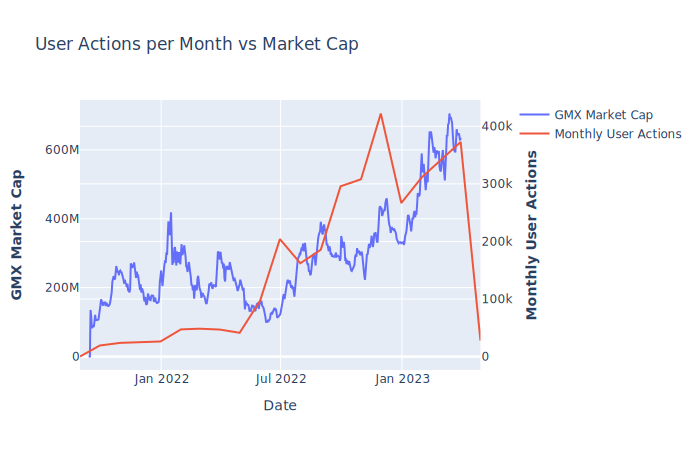

In [40]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=gmx_price['Date'].loc[(gmx_price['Date'] < '2023-04-01')], y=gmx_price['Market Cap'], name="GMX Market Cap", mode="lines"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=user_actions_monthly['Date'].loc[(user_actions['Date'] < '2023-04-01')], y=user_actions_monthly['monthly_total_user_actions'], name="Monthly User Actions", mode="lines"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="User Actions per Month vs Market Cap"
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>GMX Market Cap</b> ", secondary_y=False)
fig.update_yaxes(title_text="<b>Monthly User Actions</b> ", secondary_y=True)
fig.show(renderer="svg")

# Load GLP AUM to calculate GLP APR

Historical GLP APR data was hard to find, with the only APR calculation excluding the esGMX rewards, which makes up a large portion of APR value. https://dune.com/queries/1407298/2390170

The calculation used here:
*  Multiply fees by .99 to account for the 1% keeper cost, and multiply that by .7 to get daily GLP yield
*  Multiply the daily total esGMX emitted to GLP holders by that day's closing price to get the value of esGMX emitted that day
*  Add the daily GLP yield to the value esGMX emitted, and divide this all by daily value of the GLP pool to arrive at daily yield %. 
* Multiply by 365 to get the annual APR

In [41]:
glp_aum = pd.read_csv(r'aum_glp_supply.csv')
glp_aum['Date'] = glp_aum['Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')
gmx_price['Date'] = gmx_price['Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')
mktcap_vs_glpaum = glp_aum.merge(gmx_price, on = 'Date', how='left')

# load fees and create daily sum table
fees = pd.read_csv(r'fees.csv')
column_names = ['Swap', 'Margin trading', 'Mint GLP', 'Burn GLP', 'Liquidation']
fees['daily_total_fees']= fees[column_names].sum(axis=1)

# Calculate GLP Revenue 
fees['glp_revenue'] = fees['daily_total_fees'] * .7 * .99
fees['Date'] = fees['Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')
gmx_price['Date'] = gmx_price['Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')
glp_aum['Date'] = glp_aum['Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')
esGMX_daily['datetime_object'] = esGMX_daily['datetime_object'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')
glp_apr = fees.merge(esGMX_daily, left_on = 'Date', right_on = 'datetime_object', how = 'left')
glp_apr = glp_apr.merge(gmx_price, on = 'Date', how = 'left')
glp_apr = glp_apr.merge(glp_aum, on = 'Date', how = 'left')

# Drop NaN dates and Closing prices
glp_apr = glp_apr.dropna(subset = 'Close')

In [42]:
# Calculate APR
glp_apr['esGMX_value_emitted'] = glp_apr['esGMX_GLP'] * glp_apr['Close']

glp_apr['apr'] = (glp_apr['esGMX_value_emitted'] + glp_apr['glp_revenue'] / glp_apr['aum'])  * 365
glp_apr['portion_apr_subsidy'] = (glp_apr['esGMX_value_emitted'] / glp_apr['aum']) *365
glp_apr['portion_apr_fees'] = (glp_apr['glp_revenue'] / glp_apr['aum'])  * 365

glp_apr['portion_apr_subsidy_14'] = glp_apr['portion_apr_subsidy'].rolling(window=14).mean()
glp_apr['portion_apr_fees_14'] = glp_apr['portion_apr_fees'].rolling(window=14).mean()

glp_apr['ratio_esgMX_to_fees'] =(glp_apr['esGMX_value_emitted']/glp_apr['glp_revenue'])

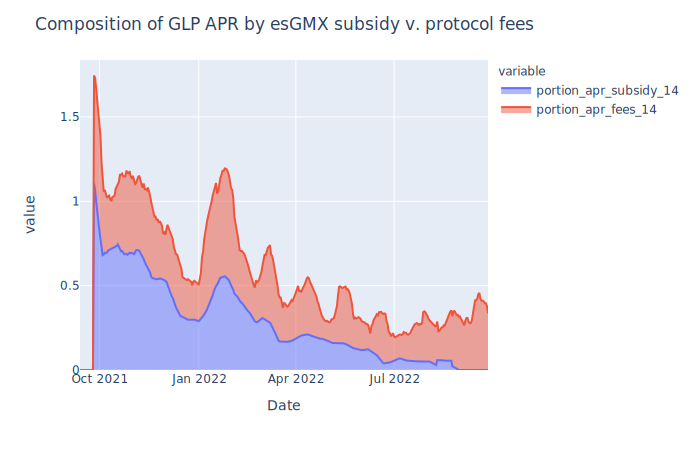

In [43]:
import plotly.express as px
df = px.data.gapminder()
fig = px.area(glp_apr.loc[(glp_apr['Date'] <= '2022-09-26')], x="Date", y=['portion_apr_subsidy_14', 'portion_apr_fees_14'])
fig.update_layout(
    title_text="Composition of GLP APR by esGMX subsidy v. protocol fees<br><sup>Rolling 14 day (starting on September 13, 2021, until August 8th, 2022)</sup>"
)
fig.show(renderer="svg")

In [44]:
glp_apr['apr'] = glp_apr['portion_apr_subsidy'] + glp_apr['portion_apr_fees']

## Ratio of subsidy/ fee revenue in GLP APR
The below dataframe is important because it shows the ratio of esGMX value emitted to GLP holders divided by the revenue from fees (70% minus 1% keeper cost). The data shows how large the subsidy was in the first ~6 months in order to attract users to provide liquidity.

In [45]:
#subsidy_ratio = glp_apr.set_index('Date')

#subsidy_ratio = glp_apr.resample('M', on='Date')['ratio_esgMX_to_fees'].mean().to_frame()

glp_apr.Date = pd.to_datetime(glp_apr.Date)
subsidy_ratio = glp_apr.set_index('Date')['ratio_esgMX_to_fees'].resample('M').mean().to_frame()
subsidy_ratio.reset_index(inplace = True)

In [46]:
subsidy_ratio.loc[(subsidy_ratio['Date'] < '2023-01-31')]

,Date,ratio_esgMX_to_fees
0,2021-09-30,2.194005
1,2021-10-31,2.263035
2,2021-11-30,1.987925
3,2021-12-31,1.460723
4,2022-01-31,1.090062
5,2022-02-28,1.645725
6,2022-03-31,0.990614
7,2022-04-30,1.373924
8,2022-05-31,0.924681
9,2022-06-30,0.888324
